Feature Visualization
======

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [2]:
num_epochs = 150
batch_size = 256
learning_rate = 1e-3
use_gpu = True
nfilters = 25

CIFAR Data Loading
-------------------

The CIFAR dataset contains 60000 32x32 colour images, split into 50000 training images and 10000 test images. Each image is labeled as one of either 10 (CIFAR10) or 100 (CIFAR100) classes.

In [3]:
import numpy as np
from skimage import color

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# augment the dataset by doing random crops and horizontal mirroring
# this is done to prevent overfitting
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=transform_train, target_transform=None, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=transform_test, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


ConvNet Definition
-----------------------
In this convolutional net, we choose a large kernel size to have a more detailed visualization

In [4]:
import numpy as np

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=9, stride=1, padding=4) # out: 48 x 32 x 32
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # out: 48 x 16 x 16
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=9, stride=1, padding=4) # out: 96 x 16 x 16
        self.conv3_bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # out: 96 x 8 x 8
        self.conv4_bn = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1) # out: 96 x 8 x 8
        self.conv5_bn = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) # out: 96 x 4 x 4
        self.conv6_bn = nn.BatchNorm2d(64)
        self.conv7 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=0) # out: 96 x 1 x 1
        self.do1 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(64, 10) # 10 outputs: probability for each CIFAR10 class

    def forward(self, x):
        # convolutional part
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = self.do1(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        
        # fully connected part
        x = F.log_softmax(self.fc1(x), dim=1) # last activation is log softmax to get log class probabilities
        
        return x

convnet = ConvNet()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
convnet = convnet.to(device)
    
# pick a subset of filters
filter_inds = []
for conv in [convnet.conv1, convnet.conv2, convnet.conv3, convnet.conv4]:
    weights = conv.weight.data.view(-1, 1, conv.weight.size(2), conv.weight.size(3))
    filter_inds.append(np.random.choice(weights.size(0), min(nfilters, weights.size(0)), replace=False))

num_params = sum(p.numel() for p in convnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 250666


Train ConvNet
--------


In [5]:
optimizer = torch.optim.Adam(params=convnet.parameters(), lr=learning_rate)

# set to training mode
convnet.train()

train_loss_avg = []

filters = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    filters.append([])
    
    for image_batch, label_batch in train_dataloader:
        
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        
        # class predictions
        prediction_batch = convnet(image_batch)
        
        # The cross-entropy loss.
        # The first input are the predicted log class probabilities.
        # The ground truth probabilites for each image are expected to be
        # 1 for a single class and 0 for all other classes.
        # This function expects as second input the index of the class with probability 1.
        # (this function is not called cross-entropy, since this function assumes
        # that the inputs are log probabilities, not probabilities).
        loss = F.nll_loss(prediction_batch, label_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    # store filters learned in this epoch
    for i, conv in enumerate([convnet.conv1, convnet.conv2, convnet.conv3, convnet.conv4]):
        weights = conv.weight.data.view(-1, 1, conv.weight.size(2), conv.weight.size(3))
        filters[-1].append(weights[filter_inds[i], :, :, :].cpu())
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 150] average loss: 1.800384
Epoch [2 / 150] average loss: 1.506838
Epoch [3 / 150] average loss: 1.355435
Epoch [4 / 150] average loss: 1.253215
Epoch [5 / 150] average loss: 1.172255
Epoch [6 / 150] average loss: 1.112579
Epoch [7 / 150] average loss: 1.058659
Epoch [8 / 150] average loss: 1.012831
Epoch [9 / 150] average loss: 0.972379
Epoch [10 / 150] average loss: 0.935343
Epoch [11 / 150] average loss: 0.902290
Epoch [12 / 150] average loss: 0.872317
Epoch [13 / 150] average loss: 0.841865
Epoch [14 / 150] average loss: 0.825446
Epoch [15 / 150] average loss: 0.798933
Epoch [16 / 150] average loss: 0.780626
Epoch [17 / 150] average loss: 0.758626
Epoch [18 / 150] average loss: 0.745468
Epoch [19 / 150] average loss: 0.729974
Epoch [20 / 150] average loss: 0.711058
Epoch [21 / 150] average loss: 0.699637
Epoch [22 / 150] average loss: 0.684781
Epoch [23 / 150] average loss: 0.676827
Epoch [24 / 150] average loss: 0.661745
Epoch [25 / 150] average loss: 0.657

Plot Training Curve
--------------------

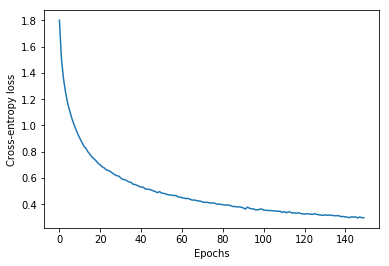

In [6]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show()

Alternatively: Load Pre-Trained Model
-----------------------------

In [7]:
filename = 'filter_vis_convnet.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
convnet.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the model parameters can be saved:
# torch.save(convnet.state_dict(), './pretrained/my_filter_vis_convnet.pth')

Evaluate on the Test Set
-------------------------

The best current methods achieve a classification error percentage of around 3.47%. See [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130) for a leaderboard.

In [8]:
# set to evaluation mode
convnet.eval()

num_incorrect = 0
test_loss_avg = 0
num_batches = 0
num_instances = 0
for image_batch, label_batch in test_dataloader:
    
    with torch.no_grad():

        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        # class predictions
        prediction_batch = convnet(image_batch)

        # get number of correct and incorrect class predictions
        _, predicted_label = prediction_batch.max(dim=1)
        num_incorrect += (predicted_label != label_batch).sum().item()

        # cross-entropy loss
        loss = F.nll_loss(prediction_batch, label_batch)

        test_loss_avg += loss.item()
        num_batches += 1
        num_instances += image_batch.size(0)
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))
print('classification error: %f%%' % ((num_incorrect / num_instances)*100))

average loss: 0.608837
classification error: 16.390000%


Filter Visualizations
-------------------------
Filters that compute useful features are usually smooth. Visualizing these filters can give an indication if the network learned something useful or rather just overfitted to the data. In our model there is some overfitting (some filters are still noisy), but most filters look relatively smooth, indicating a successful training.

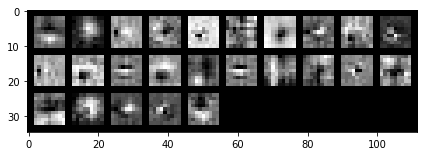

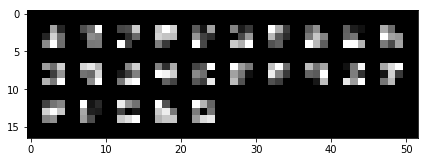

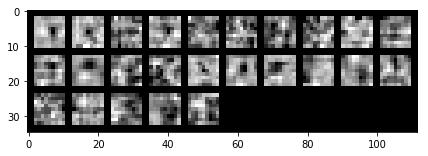

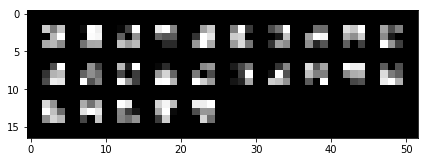

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

with torch.no_grad():

    def filter_collage(filter_weights, nrow):
        filter_max = filter_weights.view(filter_weights.size(0), 1, -1).max(dim=2)[0].view(filter_weights.size(0), 1, 1, 1)
        filter_min = filter_weights.view(filter_weights.size(0), 1, -1).min(dim=2)[0].view(filter_weights.size(0), 1, 1, 1)
        filter_weights = (filter_weights - filter_min) / (filter_max - filter_min)
        return torchvision.utils.make_grid(filter_weights, nrow=nrow)

    def show_tensor(tensor):
        fig, ax = plt.subplots(figsize=(7, 7), nrows=1, ncols=1)
        ax.imshow(np.transpose(tensor.numpy(), (1, 2, 0)))
        plt.show()

    show_tensor(filter_collage(filters[-1][0], nrow=10))
    show_tensor(filter_collage(filters[-1][1], nrow=10))
    show_tensor(filter_collage(filters[-1][2], nrow=10))
    show_tensor(filter_collage(filters[-1][3], nrow=10))